In [1]:
import matplotlib.pyplot as plt
import numpy as np
import heapq
import logging
import sys
import time
import math
from pairedCapper import PairedReads
import capper


In [3]:
start_time = time.time()
# Parse the 1kg reads

reads_1kg_small = PairedReads("minimizers_1kg_paired/minimizers_correct",
                              "minimizers_1kg_paired/minimizers_incorrect",
                              "minimizers_1kg_paired/minimizers_mixed",
                              max_correct_reads=40000)

print("Got ", len(reads_1kg_small.reads), " in ", time.time() - start_time, " seconds")

Got  55640  in  103.59122705459595  seconds


In [4]:
start_time = time.time()
# Parse the hgsvc reads

reads_hgsvc_small = PairedReads("minimizers_hgsvc_paired/minimizers_correct",
                                "minimizers_hgsvc_paired/minimizers_incorrect",
                                "minimizers_hgsvc_paired/minimizers_mixed",
                                max_correct_reads=40000)

print("Got ", len(reads_hgsvc_small.reads), " in ", time.time() - start_time, " seconds")

Got  72794  in  152.98134016990662  seconds


In [5]:
def current_cap(r):
    return r.capped_map_q  # round(min(r.uncapped_map_q, f(r.xian_cap), r.vg_computed_cap, 60))

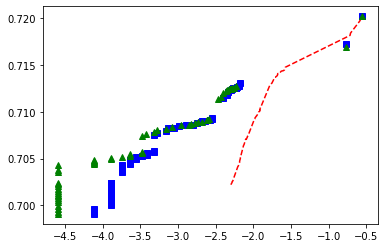

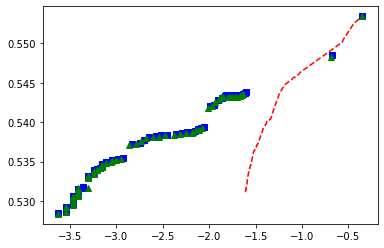

 Took  2.1038260459899902  seconds


In [45]:
## Make the small plots
def add_log(x, y):
    if (x > y):
        return x + math.log(1.0 + math.exp(y - x))
    else:
        return y + math.log(1.0 + math.exp(x - y))

def calc_map_q(r):
    if len(r.alignment_scores) == 0:
        return 0.0
   
    c = 1.38333
    
    def alignment_score(a):
        return a.score1 * c + a.score2 * c + a.log_likelihood
    
    def modified_alignment_score(a):
        #m = a.equivalent_or_better_clusters # Equivalent clusters
        #n = a.equivalent_clusters_kept # Equivalent clusters kept
        #assert m >= n
        assert a.multiplicity >= 0
        k = a.multiplicity #+ (m - n)/n
        return alignment_score(a) + (math.log(k) if k > 1 else 0.0)
    
    log_sum_exp = modified_alignment_score(r.alignment_scores[0]) 
    for a in r.alignment_scores[1:]: # Add from smallest to largest
        log_sum_exp = add_log(log_sum_exp, modified_alignment_score(a))
    
    max_score = alignment_score(r.alignment_scores[-1])
    
    if max_score == log_sum_exp:
        return capper.p_inf

    return -10 * math.log10(1.0 - math.exp(max_score - log_sum_exp))

def proposed_cap(r):    
    map_q = calc_map_q(r)
    escape_bonus = 1.0 if map_q < capper.p_inf else 2.0
    return int(min(r.xian_cap, (r.faster_cap_precomputed + 
                                r.pair.faster_cap_precomputed) * escape_bonus, map_q, 120)/2.0)

def make_rocs(reads):
    # Make ROC curves
    roc_unmodified = reads.get_roc()
    #print("Roc unmodified", roc_unmodified)
    roc_adam_modified = reads.get_roc(map_q_fn=current_cap)
    #print("Roc adam modified ", roc_adam_modified)
    start_time = time.time()
    roc_new_sum_modified = reads.get_roc(map_q_fn=proposed_cap)
    #print("Roc mode modified (time:{}) ".format(time.time()-start_time), roc_new_sum_modified)
    #Reads.plot_rocs([roc_unmodified, roc_adam_modified, roc_new_sum_modified])
    
    PairedReads.plot_rocs([roc_unmodified, roc_adam_modified, roc_new_sum_modified ])

start_time = time.time()
make_rocs(reads_1kg_small)
make_rocs(reads_hgsvc_small)
print(" Took ", time.time() - start_time, " seconds")

In [ ]:
start_time = time.time()
# Parse the hgsvc reads
reads_hgsvc = PairedReads("minimizers_hgsvc_paired/minimizers_correct",
                          "minimizers_hgsvc_paired/minimizers_incorrect",
                          "minimizers_hgsvc_paired/minimizers_mixed")
print("Got ", len(reads_hgsvc.reads), " in ", time.time() - start_time, " seconds")

In [7]:
start_time = time.time()
# Parse the 1kg reads
reads_1kg = PairedReads("minimizers_1kg_paired/minimizers_correct",
                        "minimizers_1kg_paired/minimizers_incorrect",
                        "minimizers_1kg_paired/minimizers_mixed")
print("Got ", len(reads_1kg.reads), " in ", time.time() - start_time, " seconds")

Got  2000000  in  1953.9742600917816  seconds


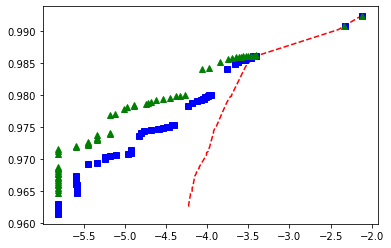

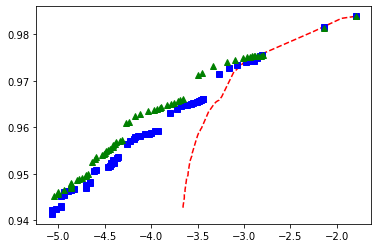

 Took  130.8554928302765  seconds


In [40]:
## Make the big plots

start_time = time.time()
make_rocs(reads_1kg)
make_rocs(reads_hgsvc)
print(" Took ", time.time() - start_time, " seconds")

In [39]:
#  Print some of the funky reads
def print_stages(reads, map_q):
    stages = {}
    total_wrong = 0
    for i, read in enumerate(reads.reads):
        if not read.correct and proposed_cap(read) >= map_q: # and read.stage == "cluster":
            #print("Read {} {}".format(i, read))
            if read.stage not in stages:
                stages[read.stage] = 0
            stages[read.stage] += 1
            total_wrong += 1
    print("Total wrong", total_wrong, "Wrong stages single end:", stages)
    
print("hgsvc")
print_stages(reads_hgsvc_small, 60)

print("1kg")
print_stages(reads_1kg_small, 60)

hgsvc
Total wrong 17 Wrong stages single end: {'cluster': 4, 'none': 7, 'extend': 4, 'winner': 2}
1kg
Total wrong 3 Wrong stages single end: {'cluster': 1, 'none': 2}
